# Multi-Factor Equity Strategy

Designing a trading strategy that:

- Uses multi-factor signals (momentum, volatility).

- Applies a Gaussian Mixture Model (GMM) to detect market regimes (bull, bear, sideways).

- Allocates portfolio weights using risk-parity optimization or minimum-variance allocation.




        Historical Prices / Returns
                   │
                   ▼
      ┌───────────────────────────┐
      │ Compute Factor Signals    │
      │ (Momentum, Volatility,    │
      │  Value, etc.)             │
      └───────────────────────────┘
                   │
                   ▼
      ┌───────────────────────────┐
      │ Standardize Factors       │
      │ - Time-series (columns)   │
      │ - Cross-sectional (rows)  │
      └───────────────────────────┘
                   │
                   ▼
      ┌───────────────────────────┐
      │ Composite Alpha Signal    │
      │ - Average of standardized │
      │   factors (with signs)    │
      └───────────────────────────┘
                   │
                   ▼
      ┌───────────────────────────┐
      │ Scale Signal to Match     │
      │ Expected Return Units     │
      └───────────────────────────┘
                   │
                   ▼
      ┌────────────────────────────────┐
      │ Portfolio Optimizer            │
      │ Objective: maximize            │
      │ wᵀ * (α + μ_baseline) - λ wᵀΣw │
      │ Constraints: long-only,        │
      │ fully invested, sector/turnover│
      └────────────────────────────────┘
                   │
                   ▼
        Optimized Portfolio Weights


## Libraries


In [ ]:
!pip install hmmlearn > /dev/null

In [ ]:
import numpy as np
import cvxpy as cp
import pandas as pd
import sklearn as sk
import yfinance as yf
import seaborn as sns
from hmmlearn import hmm
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Changing the plot theme
sns.set_theme()

## Functions

### Data

In [ ]:
# Downloading data from Yahoo Finance and taking the closing prices only
def get_price_data(tickers, start_date, end_date):
  data = yf.download(tickers, start = start_date, end = end_date, auto_adjust = True)
  return data['Close']

In [ ]:
def get_eps_data(tickers):
    eps_data = pd.DataFrame()
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        eps = stock.earnings_dates
        eps['Ticker'] = ticker
        eps_data = pd.concat([eps_data, eps], axis=0)
    return eps_data

In [ ]:
def plot_regime_hmm(hmm_signals_sp500, sorted_means_indices_hmm):
  fig = go.Figure()


  fig.update_layout(
      template="plotly_white",
      font_size=14,

      title_text="S&P 500 Value by HMM Regime",
      title_font_size=40,
      title_x=0.5,

      xaxis_title="Date",
      yaxis_title="S&P 500 Value",
      xaxis=dict(showgrid=False,),
      yaxis=dict(showgrid=False),

      font=dict(family="Open Sans", size=14),

      legend=dict(
          orientation="h",
          yanchor="bottom",
          y=1.02,
          xanchor="right",
          x=1
      ),

      height=600,
      width=1200
  )


  color_index = 0
  colors = ["#e41a1c", "#377eb8", "#4daf4a"]

  for i in sorted_means_indices_hmm:
      group_df_hmm = hmm_signals_sp500[hmm_signals_sp500['Group'] == i]
      fig.add_trace(go.Scatter(
          x=group_df_hmm.index,
          y=group_df_hmm['SP500'],
          mode='markers',
          name=f'Regime {i}',
          marker=dict(
              color=colors[color_index],
              size = 4
              )
          ))
      color_index += 1

  fig.show()

### CVXPY Portfolio Construction

#### Factor Portfolio Optimization: Mathematical Formulation

##### Objective Function
$$\max_{w} \quad w^T \cdot (\alpha + \mu) - \lambda \cdot w^T \Sigma w$$
where
$$ \alpha = \sum_{f=1}^{F} \alpha_f $$

| Symbol | Definition |
|--------|------------|
| $w$ | Portfolio weights vector $[w_1, ..., w_n]^T$ |
| $\mu$ | Expected returns vector |
| $\Sigma$ | Covariance matrix ($n \times n$) |
| $\lambda$ | Risk aversion parameter |
| $\alpha_f$ | cross-standardized factor $f$ |

In [ ]:
def cvx_optimize_factor_portfolio(factor_scores, covariance_matrix, expected_returns, risk_tolerance, print_parameters = False):

    if print_parameters:
        print("Building Porfolio using: ")
        print("\nFactor Scores: \n",factor_scores)
        print("\nCovariance Matrix: \n",covariance_matrix)
        print("\nExpected Returns: \n",expected_returns)
        print("\nRisk Tolerance: ",risk_tolerance)
        print("\nBuilding...\n\n")

    number_of_stocks = covariance_matrix.shape[0]
    x = cp.Variable(number_of_stocks)

    sigma = cp.Parameter((number_of_stocks, number_of_stocks), PSD=True)
    sigma.value = covariance_matrix

    portfolio_variance = cp.quad_form(x, sigma)

    return_with_factor = expected_returns + factor_scores * 0.0001


    objective = x.T * return_with_factor - risk_tolerance * portfolio_variance

    constraints = [
        cp.sum(x) == 1,
        x >= 0
    ]


    problem = cp.Problem(cp.Maximize(objective), constraints)

    problem.solve()


    return x

### Factors

In [ ]:
def momentum_12_1(price_df):

    price_12m = price_df.shift(252)
    price_1m= price_df.shift(21)

    momentum = (price_1m - price_12m) / price_12m

    return momentum

In [ ]:
def rolling_percentile_rank(factor_df, window_size):

    ranked_df = factor_df.rolling(window=window_size).rank(pct=True)

    return ranked_df

In [ ]:
def standardize_factor_data(factor_df, window_size):
    """
    Standardize the factor data using the rolling (based on the window size) mean and standard deviation.
    """
    rolling_mean = factor_df.rolling(window=window_size, min_periods=window_size).mean()
    rolling_std = factor_df.rolling(window=window_size, min_periods=window_size).std()

    standardized_factor_df = (factor_df - rolling_mean) / rolling_std

    return standardized_factor_df

In [ ]:
def cross_standardize(factor_df):
    cs_mean = factor_df.mean(axis=1)
    cs_std = factor_df.std(axis=1)

    cs_zscore = (factor_df.sub(cs_mean, axis=0)).div(cs_std, axis=0)

    return  cs_zscore


## Data Exploration

In [ ]:
# Tickers can be customized to whatever stock you want to look at
tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
macroTickers = ['^VIX', '^GSPC']
end_date =  pd.Timestamp.today() - pd.DateOffset(months = 6)
start_date = end_date - pd.DateOffset(years=5)

price_data = get_price_data(tickers, start_date, end_date)
macro_data = get_price_data(macroTickers, start_date, end_date)

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed


In [ ]:
# Setting the plot style
sns.set_style("ticks")

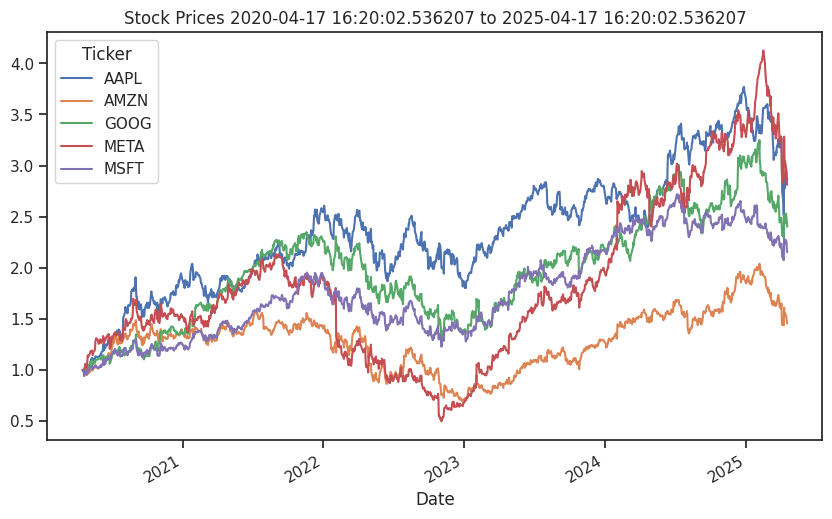

In [ ]:
# Divide the data by their first price so they all begin at 1
normalized_price_data = price_data/price_data.iloc[0]
normalized_price_data.plot(figsize = (10,6), title = f'Stock Prices {start_date} to {end_date}')


plt.show()

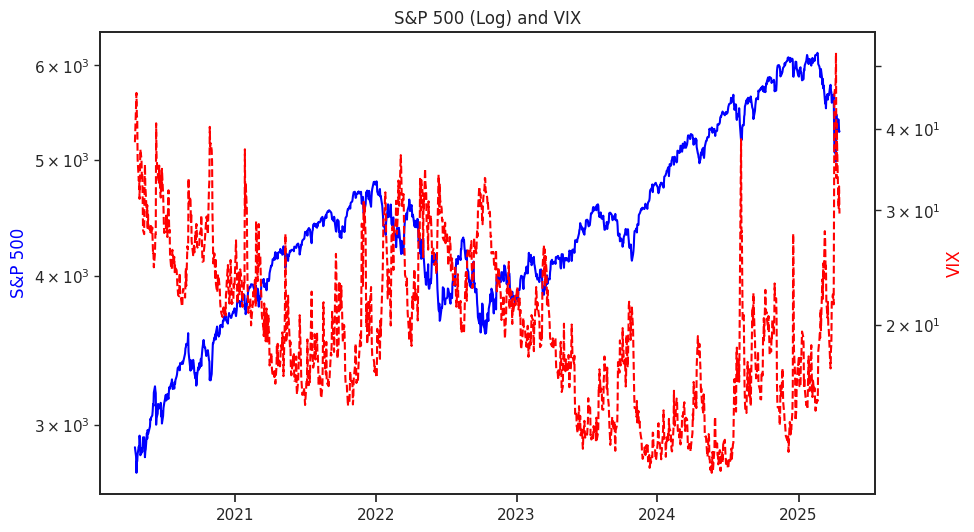

In [ ]:
# Renaming the columns
macro_data.rename(columns={'^GSPC':'SP500', '^VIX': 'VIX'}, inplace=True)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_title("S&P 500 (Log) and VIX")
ax1.set_ylabel("S&P 500", color='blue')
ax1.plot(macro_data.index, macro_data['SP500'], color='blue')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.set_ylabel("VIX", color='red')
ax2.plot(macro_data.index, macro_data['VIX'], color = 'red', linestyle='--')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='red')

plt.show()

## Market Regime

We will use a Gaussian Mixture Model (GMM) to classify the market regimes for our model. Here, GMM performs the task of clustering, placing the market intos three different groups (regimes).

In [ ]:
returns_sp500 = np.log(macro_data['SP500']/macro_data['SP500'].shift(1)).dropna()

hmm_model = hmm.GaussianHMM(n_components=3)
hmm_model.fit(returns_sp500.values.reshape(-1, 1))
hmm_groups = hmm_model.predict(returns_sp500.values.reshape(-1, 1))

hmm_signals_sp500 = pd.concat([macro_data['SP500'], pd.DataFrame(hmm_groups, index = returns_sp500.index), returns_sp500], axis=1)
hmm_signals_sp500.columns = ['SP500', 'Group', 'Returns']

hmm_signals_sp500.dropna(inplace=True)
display(hmm_signals_sp500.head())
display(hmm_signals_sp500.tail())

,SP500,Group,Returns
Date,,,
2020-04-20,2823.159912,2.0,-0.018043
2020-04-21,2736.560059,0.0,-0.031155
2020-04-22,2799.310059,1.0,0.022671
2020-04-23,2797.800049,1.0,-0.000540
2020-04-24,2836.739990,1.0,0.013822


,SP500,Group,Returns
Date,,,
2025-04-11,5363.359863,1.0,0.017930
2025-04-14,5405.970215,1.0,0.007913
2025-04-15,5396.629883,1.0,-0.001729
2025-04-16,5275.700195,0.0,-0.022663
2025-04-17,5282.700195,1.0,0.001326


[[-0.00149853]
 [ 0.00145884]
 [-0.00400793]]
[2 0 1] 

Group: 2
Regime: Bear
Mean: [-0.00400793]
Covariances (Σ): [[0.00062505]]

Group: 0
Regime: Neutral
Mean: [-0.00149853]
Covariances (Σ): [[0.00023112]]

Group: 1
Regime: Bull
Mean: [0.00145884]
Covariances (Σ): [[7.92471505e-05]]


 Probability Transition Matrix:


array([[0.   , 0.825, 0.175],
       [0.203, 0.75 , 0.047],
       [0.634, 0.314, 0.052]])

[]

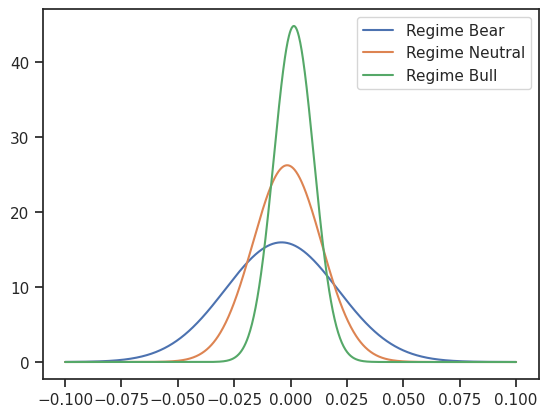

In [ ]:
print(hmm_model.means_)
print(np.argsort(hmm_model.means_.flatten()),"\n")

sorted_means_indices_hmm = np.argsort(hmm_model.means_.flatten(),)
state_space = ["Bear", "Neutral", "Bull"]

x = np.linspace(-0.1, 0.1, 1000)

for regime, state in zip(sorted_means_indices_hmm, state_space):
    print(f"Group: {regime}")
    print(f"Regime: {state}")
    print(f"Mean: {hmm_model.means_[regime]}")
    print(f"Covariances (Σ): {hmm_model.covars_[regime]}\n")

    y = norm.pdf(x, hmm_model.means_[regime][0], np.sqrt(hmm_model.covars_[regime][0]))
    plt.plot(x, y, label=f'Regime {state}')

print("\n Probability Transition Matrix:")
display(np.round(hmm_model.transmat_, 3))


plt.legend()
plt.plot()

In [ ]:
plot_regime_hmm(hmm_signals_sp500, sorted_means_indices_hmm)

## Portfolio Construction

#### Test Data

In [ ]:
# Testing Portfolio Dates
start_date_portfolio = end_date+pd.DateOffset(days=1)
end_date_portfolio = pd.Timestamp.today()

In [ ]:
data_portfolio = get_price_data(tickers, start_date_portfolio, end_date_portfolio)
data_macro_portfolio = get_price_data(macroTickers, start_date_portfolio, end_date_portfolio)

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completed


In [ ]:
price_data = pd.concat([price_data, data_portfolio])
display(price_data)

Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2019-10-17,56.653156,89.374001,62.227657,189.223480,132.430634
2019-10-18,56.925243,87.875504,61.851238,184.711334,130.269180
2019-10-21,57.912495,89.282997,61.884010,188.597336,131.236145
2019-10-22,57.780045,88.286499,61.717651,181.222824,129.283173
2019-10-23,58.555393,88.108498,62.528603,185.009460,130.107971
...,...,...,...,...,...
2025-10-13,247.660004,220.070007,244.639999,715.700012,514.049988
2025-10-14,247.770004,216.389999,246.190002,708.650024,513.570007
2025-10-15,249.339996,215.570007,251.710007,717.549988,513.429993


### Factor Scores

#### Momentum (12 month - 1 month return)

In [ ]:
returns_price_data_12_1 = price_data.pct_change(231).shift(21).dropna()
display(returns_price_data_12_1.tail())
print(returns_price_data_12_1.dropna().shape)

Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2025-10-13,0.024481,0.232111,0.486793,0.282713,0.230604
2025-10-14,0.038254,0.239914,0.549589,0.313031,0.248627
2025-10-15,0.051454,0.239540,0.534892,0.323709,0.231893
2025-10-16,0.038056,0.235043,0.508527,0.317087,0.225960
2025-10-17,0.021968,0.231978,0.518480,0.334156,0.223354


(1257, 5)


In [ ]:
z_returns_price_data_12_1 = standardize_factor_data(factor_df = returns_price_data_12_1, window_size = 252).dropna()
display(z_returns_price_data_12_1.tail())
print(z_returns_price_data_12_1.dropna().shape)

Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2025-10-13,-0.813382,-0.098626,1.837627,-0.787395,1.084969
2025-10-14,-0.724372,-0.042180,2.173010,-0.641072,1.240894
2025-10-15,-0.639511,-0.040052,2.061206,-0.586338,1.105281
2025-10-16,-0.715534,-0.065556,1.888313,-0.611885,1.062266
2025-10-17,-0.807495,-0.081151,1.922310,-0.526726,1.049016


(1006, 5)


#### Volatility

In [ ]:
volatility_price_data = price_data.pct_change().rolling(window=30).std().dropna()
display(volatility_price_data.tail())
print(volatility_price_data.shape)

Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2025-10-13,0.017108,0.017886,0.021435,0.014311,0.010490
2025-10-14,0.016943,0.017908,0.021316,0.014387,0.010471
2025-10-15,0.015592,0.017897,0.014515,0.014588,0.010473
2025-10-16,0.015662,0.015826,0.014503,0.014298,0.010462
2025-10-17,0.015670,0.015835,0.014474,0.014259,0.009284


(1479, 5)


In [ ]:
z_volatility_price_data = standardize_factor_data(factor_df = volatility_price_data, window_size = 252).dropna()
display(z_volatility_price_data.dropna().tail())
print(z_volatility_price_data.shape)

Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2025-10-13,-0.113569,-0.331026,0.425544,-0.788074,-0.709913
2025-10-14,-0.131809,-0.327987,0.397888,-0.779757,-0.712248
2025-10-15,-0.274867,-0.329699,-0.927401,-0.757298,-0.711159
2025-10-16,-0.267766,-0.633544,-0.928950,-0.790542,-0.712292
2025-10-17,-0.267598,-0.631870,-0.936665,-0.795552,-0.918916


(1228, 5)


<Axes: title={'center': '12-1 Momentum'}, xlabel='Date'>

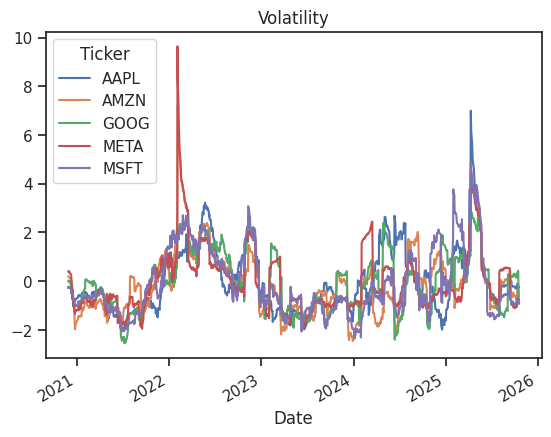

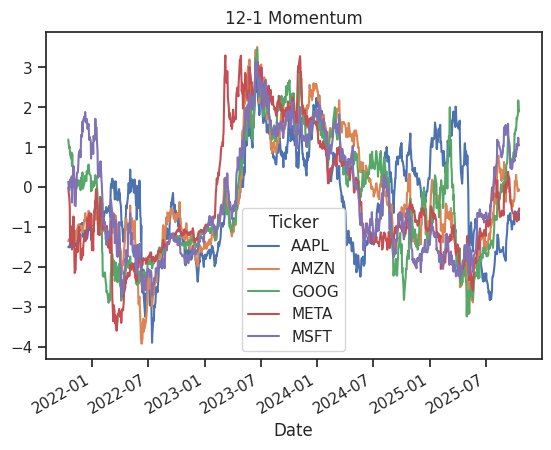

In [ ]:
z_volatility_price_data.plot(title = "Volatility")
z_returns_price_data_12_1.plot(title = "12-1 Momentum")

#### Combine and Rank Factors

In [ ]:
cz_returns_price_data_12_1 = cross_standardize(z_returns_price_data_12_1)
cz_volatility_price_data = cross_standardize(z_volatility_price_data)
cz_combined = cz_returns_price_data_12_1.add(cz_volatility_price_data).dropna()
display(cz_combined.tail())
print(cz_combined.shape)

Ticker,AAPL,AMZN,GOOG,META,MSFT
Date,,,,,
2025-10-13,-0.512687,-0.347651,2.834408,-1.861517,-0.112552
2025-10-14,-0.516219,-0.386685,2.882511,-1.804602,-0.175006
2025-10-15,0.274979,0.593162,0.281622,-1.377226,0.227464
2025-10-16,0.697289,-0.200707,0.339604,-1.317075,0.480889
2025-10-17,0.628065,-0.058776,0.585084,-1.041372,-0.113002


(1006, 5)


### Portfolio

In [ ]:
portfolio_weights = cvx_optimize_factor_portfolio(factor_scores = cz_combined.iloc[-1], covariance_matrix=price_data.pct_change().cov().values, expected_returns=price_data.pct_change().mean().values, risk_tolerance=.9, print_parameters=True)
portfolio_weights.value = np.array(portfolio_weights.value).flatten()

np.set_printoptions(suppress=True, precision=8)
print("Optimized Portfolio: ")
df_portfolio_weights = pd.DataFrame(portfolio_weights.value, index = price_data.columns, columns = ['Weight'])
print(df_portfolio_weights)
np.set_printoptions(suppress=False)

portfolio_weights.value.sum()


Building Porfolio using: 

Factor Scores: 
 Ticker
AAPL    0.628065
AMZN   -0.058776
GOOG    0.585084
META   -1.041372
MSFT   -0.113002
Name: 2025-10-17 00:00:00, dtype: float64

Covariance Matrix: 
 [[0.00040183 0.00026453 0.00025316 0.00030498 0.00026507]
 [0.00026453 0.0004944  0.00028689 0.00038062 0.00027786]
 [0.00025316 0.00028689 0.0004039  0.00034359 0.00026635]
 [0.00030498 0.00038062 0.00034359 0.000751   0.00031687]
 [0.00026507 0.00027786 0.00026635 0.00031687 0.00034338]]

Expected Returns: 
 [0.00118122 0.00081776 0.00112673 0.00125454 0.00106625]

Risk Tolerance:  0.9

Building...


Optimized Portfolio: 
              Weight
Ticker              
AAPL    6.125343e-01
AMZN   -9.895757e-23
GOOG    3.874657e-01
META   -6.548110e-23
MSFT    6.231038e-23


np.float64(1.0)

### Backtesting

In [ ]:
def backtest_portfolio(returns, portfolio_weights):
  portfolio_returns = returns.dot(portfolio_weights)
  cumulative_returns = (1 + portfolio_returns).cumprod()
  return cumulative_returns

## Results